In [3]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#https://github.com/amueller/word_cloud

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import regex as re
from collections import Counter

#So I can see multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#Load the extra clean data
df = pd.read_csv('recipe_overclean.csv', sep = ",", quotechar = '"', dtype=object, index_col=0)
df["TotalIng"] = pd.to_numeric(df["TotalIng"])

In [5]:
df.sample(2)

,Website,Link,Title,TotalTime,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,TotalIng
22472,epicurious,https://www.epicurious.com/recipes/food/views/...,Beef and Broccoli Stir Fry,0,1/4 cup soy sauce,1/4 cup dry Sherry,1 tablespoon honey,"1 tablespoon , chopped garlic",2 teaspoons grated orange peel,"1 pound flank steak, cut diagonally across gra...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66
45151,epicurious,https://www.epicurious.com/recipes/food/views/...,Rosemary Focaccia,0,"a 1/4-ounce package , active dry yeast",1/2 teaspoon sugar,1 cup lukewarm water,3 1/2 cups unbleached all-purpose flour,1 teaspoon table salt,5 tablespoons olive oil,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67


In [6]:
#View some summary data by website
agg1 = df.groupby("Website").size()
agg2 = 76 - df.groupby('Website')[["TotalIng"]].mean()
website = pd.concat([agg1, agg2], axis=1, sort=False)
website.rename(columns={0: 'NumRecipes', 'TotalIng': 'AveNumIngr'}, inplace=True)
website

,NumRecipes,AveNumIngr
Website,,
100daysofrealfood,8,14.250000
101cookbooks,15,13.200000
101cookingfortwo,5,10.600000
12tomatoes,40,16.075000
196flavors,3,18.333333
1mrecipes,2,15.000000
247lowcarbdiner,1,11.000000
28cooks,1,14.000000
2stews,2,27.000000


In [ ]:
# Summary statistic of each website's recipes
wb_topsum = website.sort_values(by='NumRecipes',ascending=False).head(20)
wb_topave = website.sort_values(by='AveNumIngr',ascending=False).head(20)

In [ ]:
#View the reason we are only going to look at the top websites for the below visualization
wb_topsum
wb_topave

,NumRecipes,AveNumIngr
Website,,
tastykitchen,39387,10.129383
epicurious,33828,9.758218
foodnetwork,13957,12.386258
bonappetit,12464,10.642089
cookstr,7009,10.277786
foodrepublic,3617,11.704451
food,2429,12.484562
finedininglovers,1844,11.404555
whatsgabycooking,1161,11.171404


,NumRecipes,AveNumIngr
Website,,
balancingcinderella,1,58.000000
mannaandspice,1,42.000000
autoimmunewellness,1,41.000000
forbiddenriceblog,2,40.500000
safeeggs,1,37.000000
online,1,37.000000
link,1,36.000000
thetiffinbox,1,36.000000
culinaryorgasm-karen,1,35.000000


<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5, 1.0, 'Number of Recipes per top 20 Sites')

Text(0.5, 0, 'Website of Origin')

Text(0, 0.5, 'Number of Recipes')

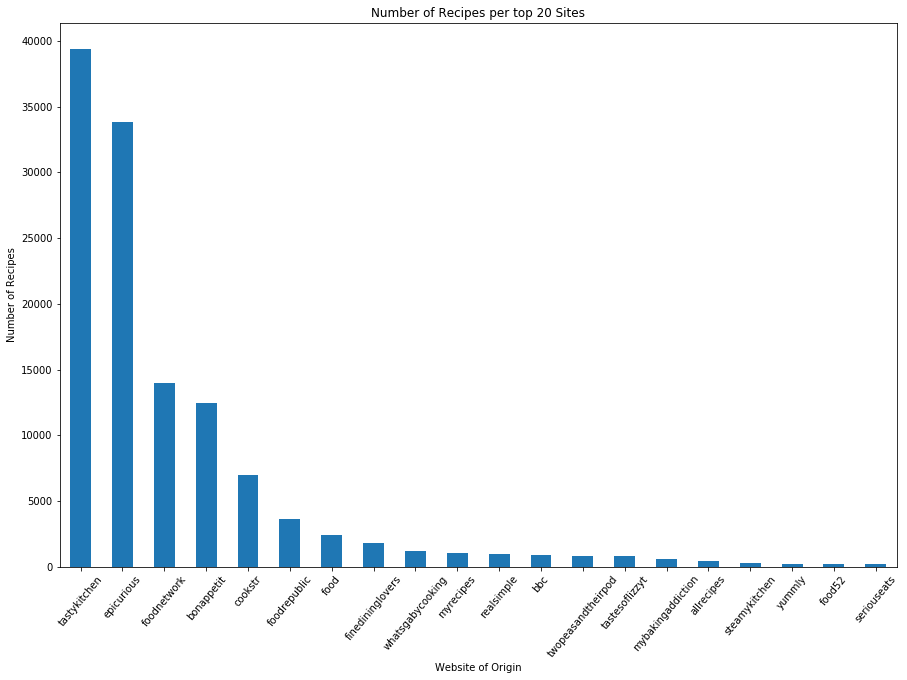

In [ ]:
plt.figure(figsize=(15,10))
wb_topsum.NumRecipes.sort_values(ascending=False).plot.bar()

plt.xticks(rotation=50)
plt.title('Number of Recipes per top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Number of Recipes")
plt.show()

<Figure size 1080x720 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

Text(0.5, 1.0, 'Average Number of Ingredients per Recipe in top 20 Sites')

Text(0.5, 0, 'Website of Origin')

Text(0, 0.5, 'Average Number of Ingredients')

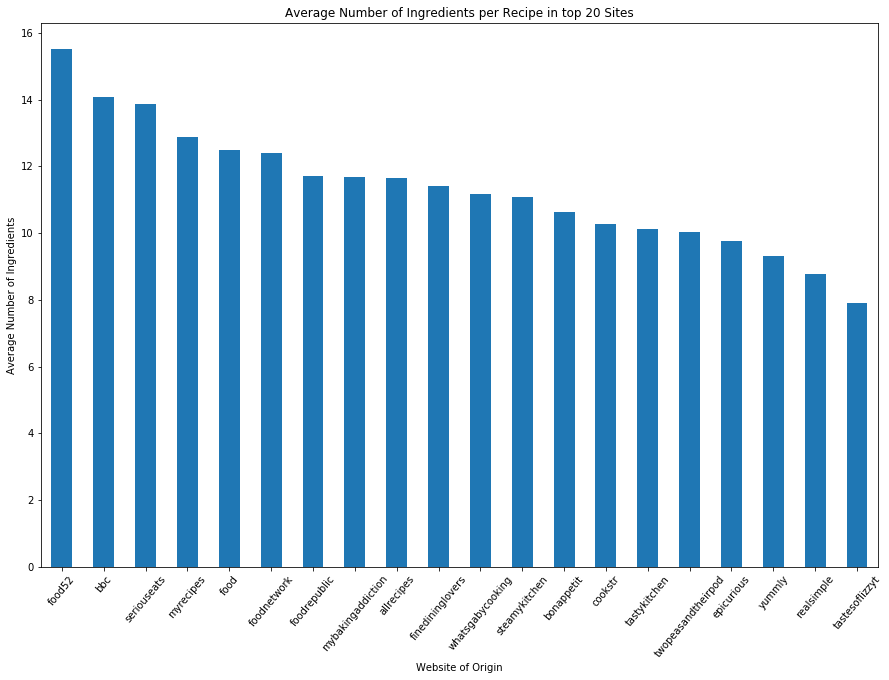

In [ ]:
plt.figure(figsize=(15,10))
wb_topsum.AveNumIngr.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Average Number of Ingredients per Recipe in top 20 Sites')
plt.xlabel("Website of Origin")
plt.ylabel("Average Number of Ingredients")
plt.show()

In [ ]:
#Read in 
ingredients = pd.read_csv('ingredients_agg.csv', names = ['Title','AggIngredients'], sep = ",", quotechar = '"', skipinitialspace=True, error_bad_lines = False, dtype=object)

In [ ]:
#Cleanup separate commas, all lowercase, stem select words
ingredients.Title = ingredients.Title.str.replace(',',' , ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(',',' , ')
ingredients.Title = ingredients.Title.str.replace('(',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('(',' ')
ingredients.Title = ingredients.Title.str.replace(')',' ')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace(')',' ')

ingredients.Title = ingredients.Title.str.lower()
ingredients.AggIngredients = ingredients.AggIngredients.str.lower()

ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('potatoes','potato')
ingredients.Title = ingredients.Title.str.replace('potatoes','potato')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('tomatoes','tomato')
ingredients.Title = ingredients.Title.str.replace('eggs','egg')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('eggs','egg')
#regex? clove * garlic, garlic clove
ingredients.Title = ingredients.Title.str.replace('garlic clove','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('garlic clove','garlic')
ingredients.Title = ingredients.Title.str.replace('cloves of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('cloves of garlic','garlic')
ingredients.Title = ingredients.Title.str.replace('clove of garlic','garlic')
ingredients.AggIngredients = ingredients.AggIngredients.str.replace('clove of garlic','garlic')

#!?


In [ ]:
ingredients.AggIngredients.head()

Website                                                 aggingredients
100daysofrealfood    1½ pounds potato  ,  ,  1 1/2 pounds potato su...
101cookbooks         toasted sesame oil ,  1 cup whole coconut milk...
101cookingfortwo     2 pounds of skinless boneless chicken breast  ...
12tomatoes           1/2 onion ,  diced ,  3/4 cup plain greek yogu...
Name: AggIngredients, dtype: object

In [ ]:
wordfreq_Title = ingredients.Title.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [ ]:
wordfreq_Title = wordfreq_Title[3:]

In [ ]:
wordfreq_AggIng = ingredients.AggIngredients.apply(lambda x: pd.value_counts(str(x).split(" "))).sum(axis = 0)

In [ ]:
wordfreq_AggIng = wordfreq_AggIng[4:]

In [ ]:
#View word count on Recipe Title
plt.figure(figsize=(15,10))
wordfreq_Title.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

<Figure size 1080x720 with 0 Axes>

(array([    0,     1,     2, ..., 25226, 25227, 25228]),
 <a list of 25229 Text xticklabel objects>)

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

Ridiculous, so let's look at a smaller data set

In [ ]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

Remove high frequency words ",", "with", "and" by adding to stopwords.

In [ ]:
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stop1 = ['a', 'and', 'the', 'or', 'of', 'if', 'on', 'but','with','®',
        'pinch', 'left', 'peeled', 'cut', 'chopped', 'sliced','&',
        'small', 'medium', 'large', 'whole', 'into', 'in', 'to',
        'plus', 'more', 'thick', 'halved', 'quartered', 'good',
        'inch', 'inches', 'about', 'sea', 'end', 'approximate',
        'approximately', 'very', 'finely', 'for', 'nan', 'none', 
         'recipe', 'freshly','ground']
measurement = ['teaspoon', 'tsp', 'tablespoon', 'tbsp','sprigs','sprig',
               'teaspoons', 'tablespoons', 
                'ounce', 'oz', 'cup', 'pint', 'pt', 
                'ounces', 'cups', 'pints',
                'quart', 'qt', 'gallon', 'gal',
                'quarts', 'gallons',
               'pound', 'lb', 'gram', 'kilogram',
               'pounds', 'lbs', 'grams', 'kilograms',
                'milliliter', 'liter', 'weight',
                'milliliters', 'liters']
amounts = ["1", "one", "2", "two", "3", 'three','4','four',
           '5','five','6','six','7','seven','8','eight','9',
           'nine','10','ten','½', '1/2','half', '1½','¼','1/4','3/4','⅓','1/3','¾','1-½','12']
stopwords.update(stop1,measurement,amounts)

In [ ]:
#Remove stopwords 
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwords)]
wordfreq_Title = wordfreq_Title[~wordfreq_Title.index.isin(stopwords)]

In [ ]:
wordfreq_Title_top = wordfreq_Title.sort_values(ascending=False).head(50)
wordfreq_Title_top
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Title_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Frequency of the top 50 words in all scraped recipe titles')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Frequency of the top 50 words in all scraped recipe ingredient lists')
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#Remove adj and verbs
stopwordsExtra = stopwords.copy()
stopwordsExtra.update(['fresh','black','red','powder','minced','white',
                       'grated','kosher','unsalted','leaves','sauce','baking',
                      'dried','diced','thinly','extract','divided','brown','pieces',
                      'green','taste','slices','seeds','dry','room','temperature',
                      'all-purpose','shredded','crushed','drained','coarsely',
                      'heavy','frozen','granulated','melted','softened','trimmed',
                       'toasted','yellow','removed','cubes','cooked','light','seeded','powdered'])

In [ ]:
wordfreq_AggIng = wordfreq_AggIng[~wordfreq_AggIng.index.isin(stopwordsExtra)]
wordfreq_Ing_top = wordfreq_AggIng.sort_values(ascending=False).head(50)
wordfreq_Ing_top

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_top.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Frequency of the top 50 ingredients in all scraped recipe ingredient lists')
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.show()

In [ ]:
wordfreq_Ing_prop = wordfreq_AggIng.sort_values(ascending=False).head(50)/len(df)

In [ ]:
plt.figure(figsize=(15,10))
wordfreq_Ing_prop.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.title('Proportion of recipes containing given ingredient')
plt.xlabel("Word")
plt.ylabel("Proportion")
plt.show()

In [ ]:
def wc(site,section, pic=None):
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white",mask=pic).generate(ingredients.loc[site,section])
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
food_mask = np.array(Image.open("Img/CoveredHotPlate.jpg"))
food_mask

chicken_mask = np.array(Image.open("Img/Chicken.jpg"))
chicken_mask

In [ ]:
#swap number 0 to 255
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [ ]:
#Sometimes the mask needs to be transformed?
#Transform your mask into a new one that will work with the function:
transformed_food_mask = np.ndarray((food_mask.shape[0],food_mask.shape[1]), np.int32)

for i in range(len(food_mask)):
    for j in range(len(food_mask[i])):
        transformed_food_mask[i][j] = list(map(transform_format, food_mask[i][j]))

In [ ]:
wb_topsum

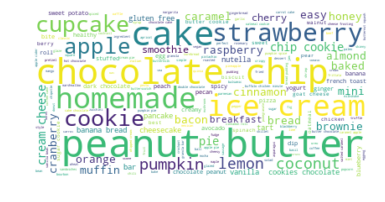

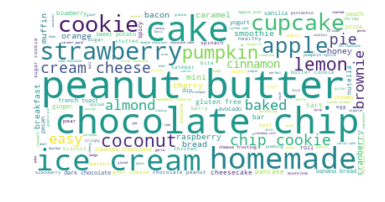

In [577]:
wc('tastykitchen','Title')

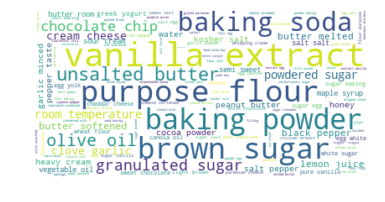

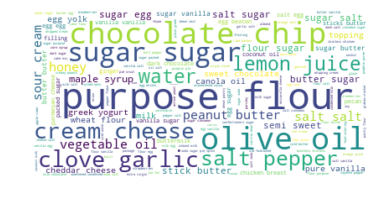

In [578]:
wc('tastykitchen','AggIngredients')

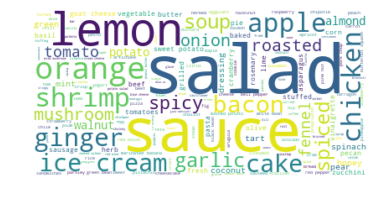

In [476]:
wc('epicurious','Title')

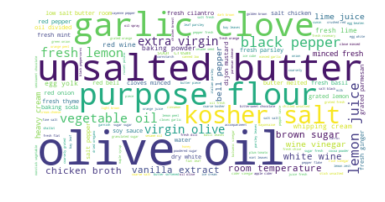

In [477]:
wc('epicurious','AggIngredients')

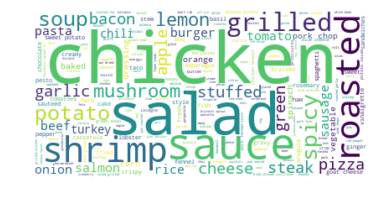

In [478]:
wc('foodnetwork','Title')

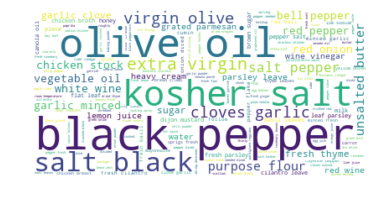

In [479]:
wc('foodnetwork','AggIngredients')

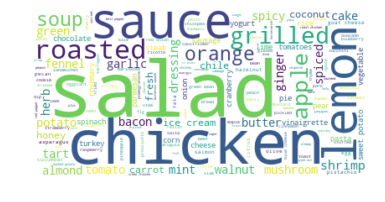

In [480]:
wc('bonappetit','Title')

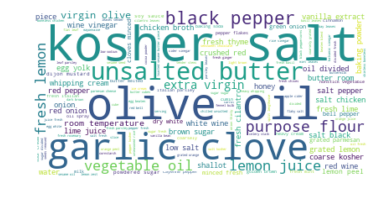

In [481]:
wc('bonappetit','AggIngredients')

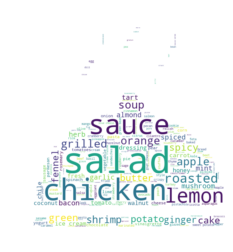

In [482]:
wc('bonappetit','Title',food_mask)

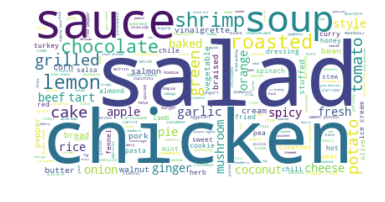

In [483]:
wc('cookstr','Title')

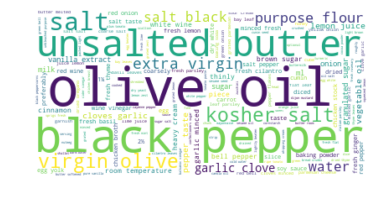

In [484]:
wc('cookstr', 'AggIngredients')

In [ ]:
ingredients['Title'].str.cat()

(-0.5, 399.5, 199.5, -0.5)

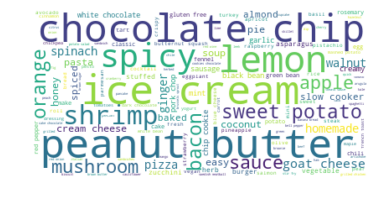

In [485]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ingredients['Title'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

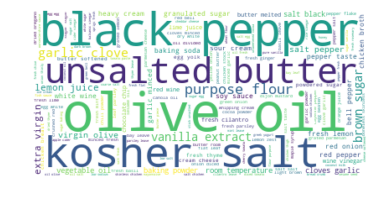

In [486]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(ingredients['AggIngredients'].str.cat())
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This dataset started its life on a various recipe database websites.  Through webscraper code, utilizing BeautifulSoup and open source code as a base, the initial csv of 155,876 lines listed the url, recipe title, total time, and each ingredient as a separate column.  Recipe titles or ingredients which internally contained commas were surrounded by double quotes.

The recipe scraper provides ingredients as they are written within the websites. We will need to parse out the amounts from the ingredients themselves and occasionally additional instructions. (1 10-oz. package frozen blackberries (about 2 cups), thawed) (2 large fresh fennel bulbs, trimmed, each cut vertically into 12 wedges with some core attached) The amounts and the ingredients will need to be normalized to merge with the nutritional dataset.